# Fake News Modeling

# Table of Contents
- [Imports](#Import:)
- [Load Full Data](#Load-Full-Data:)
- [Modeling/Evaluation](#Model-/-Evaluation:)
    - [Data Prep](#Data-Prep:)
    - [Evaluation Functions](#Evaluation-Functions:)
    - [Naive Bayes](#Naive-Bayes:)
    - [Log Reg](#Log-Reg:)
    - [Random Forest](#Random-Forest:)
    - [Decision Tree](#Decision-Tree:)
    - [KNN](#KNN:)
    - [SVC](#SVC:)

# Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import requests 
import time
import datetime as dt
import nltk, string, re
import gensim
import warnings
import pickle
import joblib

## Model considerations and downloads
from statsmodels.api import OLS
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)
from sklearn.svm import SVC

## Train Test Splits and scoring
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, 
                                plot_roc_curve, roc_auc_score, precision_score, 
                                f1_score, recall_score, ConfusionMatrixDisplay)

## NLP Considerations
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

# Load Full Data:

In [3]:
Full_df = pd.read_csv('../Data/retrain.csv')


In [4]:
Full_df.head()

,text,cleanText,target,date
0,Donald Trump just couldn t wish all Americans ...,donald trump wish american happy new year leav...,1,2017-12-31
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,1,2017-12-31
2,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...,1,2017-12-30
3,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...,1,2017-12-29
4,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...,1,2017-12-25


In [5]:
Full_df.isna().sum()

text         0
cleanText    0
target       0
date         0
dtype: int64

# Modeling/Evaluation:

#### Data Prep:

In [6]:
# Set up the X and y
X = Full_df["cleanText"]
y = Full_df["target"]

In [7]:
X

0        donald trump wish american happy new year leav...
1        house intelligence committee chairman devin nu...
2        friday revealed former milwaukee sheriff david...
3        christmas day donald trump announced would bac...
4        pope francis used annual christmas day message...
                               ...                        
77833               democracy work post citizen united era
77834    republican congressman greg gianforte half hea...
77835              additional flexibility good client well
77836    despite promise would sacrifice need ordinary ...
77837    increasingly convinced real reason ringling br...
Name: cleanText, Length: 77838, dtype: object

In [8]:
# Establish a baseline
y.value_counts(normalize=True)

0    0.524256
1    0.475744
Name: target, dtype: float64

#### Evaluation Functions:

In [9]:
def classify_score(model = None, X_train = None, X_test = None, y_train = None, y_test = None):
    # Score model on training set.
    print(f'Training Score: {model.score(X_train, y_train)}')

    # Score model on testing set.
    print(f'Testing Score: {model.score(X_test, y_test)}')

In [10]:
def classifiy_metrics(y_test = None, y_preds= None, title = None):
    
    # Calculates the metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    accuracy = accuracy_score(y_test,y_preds)
    recall = recall_score(y_test,y_preds)
    precision = precision_score(y_test,y_preds)
    specificity = tn/(tn + fp)
    F1score = f1_score(y_test,y_preds)
    roc_auc = roc_auc_score(y_test,y_preds)
    
    # Print Metrics
    print(f"Accuracy Score: {accuracy}")
    print(f"Recall Score: {recall}")
    print(f"Specificity Score: {specificity}")
    print(f"Precision Score: {precision}")
    print(f"F1 Score: {F1score}")
    print(f"ROC AUC Score: {roc_auc}")

    # Lastly create the confusion matrix plots
    fig, ax = plt.subplots(figsize=(10,10))
    plt.rcParams.update({'font.size': 22})
    plt.grid(False)
    ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Blues', values_format='d', ax=ax).ax_.set_title(title)
    #Confusion Matrix set title https://github.com/scikit-learn/scikit-learn/discussions/20690
    #figure size https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
    #Grid line removal https://stackoverflow.com/questions/53574918/how-to-get-rid-of-white-lines-in-confusion-matrix
    # Confusion Matrix Font Size https://stackoverflow.com/questions/67294768/how-can-i-change-the-font-size-in-this-confusion-matrix

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,
                                                    stratify=y, random_state=42)

In [11]:
X_train

16472    daily dose insanity san francisco middle schoo...
71840    standing thousand iowa voter former vice presi...
55255    jeff stein vox hillary clinton found win dilem...
49160    freedom rider dump democrat good margaret kimb...
23568    washington reuters u department defense lockhe...
                               ...                        
18828    washington reuters trump administration order ...
36220    sydney reuters second group refugee held austr...
51255    november next step clean democratic party oppo...
25111    washington reuters u president barack obama we...
41522    man spoke softly carried big stick bill federe...
Name: cleanText, Length: 52151, dtype: object

In [12]:
y_train

16472    1
71840    0
55255    1
49160    1
23568    0
        ..
18828    0
36220    0
51255    1
25111    0
41522    1
Name: target, Length: 52151, dtype: int64

#### Naive Bayes:

In [13]:
ct_pipe_mnb_np = Pipeline([
    ('tvec', TfidfVectorizer()),                                   
    ('mnb', MultinomialNB())
])

pipe_params_ct_mnb_np = {
        'tvec__max_df' : [0.95, 0.98],
        'tvec__ngram_range' : [(1, 1), (2,2)],
        'tvec__min_df' : [0.01, 0.02]
}

# Instantiate GridSearchCV.
gs_ct_mnb_np = GridSearchCV(ct_pipe_mnb_np,
                      param_grid=pipe_params_ct_mnb_np,
                      cv=5,
                      verbose=2,
                      n_jobs=-2)


In [14]:
gs_ct_mnb_np.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'tvec__max_df': [0.95, 0.98],
                         'tvec__min_df': [0.01, 0.02],
                         'tvec__ngram_range': [(1, 1), (2, 2)]},
             verbose=2)

In [15]:
gs_ct_mnb_np.best_params_

{'tvec__max_df': 0.95, 'tvec__min_df': 0.01, 'tvec__ngram_range': (2, 2)}

In [16]:
classify_score(model = gs_ct_mnb_np, 
                X_train = X_train, 
                X_test = X_test, 
                y_test = y_test, 
                y_train = y_train)

Training Score: 0.7922762746639566
Testing Score: 0.7883365126328493


In [17]:
preds_gs_mnb_np = gs_ct_mnb_np.predict(X_test)

Accuracy Score: 0.7883365126328493
Recall Score: 0.6869067103109656
Specificity Score: 0.8803742481621742
Precision Score: 0.8389805097451274
F1 Score: 0.7553655793025872
ROC AUC Score: 0.7836404792365699


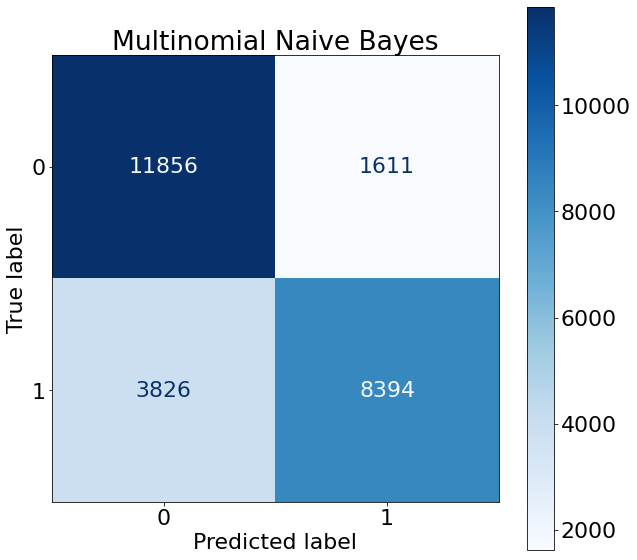

In [55]:
classifiy_metrics(y_test = y_test, 
                    y_preds = preds_gs_mnb_np,
                    title="Multinomial Naive Bayes")

In [19]:
joblib.dump(gs_ct_mnb_np,'retrain_gs_ct_mnb_np.pkl')

['retrain_gs_ct_mnb_np.pkl']

#### Log Reg:

In [20]:
# Complex Log Reg With Passthrough for Words Per Title and Per Text

cvec_idf_logreg_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('logreg', LogisticRegression())
])

pipe_params_cidf_logreg = {
        'cvec__ngram_range' : [(1, 1), (2, 2)],
        'cvec__min_df' : [0.01, 0.02],
        'cvec__max_df': [0.95, 0.98],
        'tfidf__use_idf': [True, False],
        'logreg__C': (0.1, 0.5),
        'logreg__penalty': ('l1', 'l2'),
        'logreg__solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
}

# Instantiate GridSearchCV.
gs_cvec_idf_logreg = GridSearchCV(cvec_idf_logreg_pipe,
                      param_grid=pipe_params_cidf_logreg,
                      cv=5,
                      verbose=1,
                      n_jobs=-2)


# Fit GridSearch to training data.
gs_cvec_idf_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
480 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penal

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.95, 0.98],
                         'cvec__min_df': [0.01, 0.02],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'logreg__C': (0.1, 0.5),
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ('newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga'),
                         'tfidf__use_idf': [True, False]},
             verbose=1)

In [21]:
gs_cvec_idf_logreg.best_params_

{'cvec__max_df': 0.98,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'logreg__C': 0.5,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga',
 'tfidf__use_idf': True}

In [22]:
classify_score(model = gs_cvec_idf_logreg, 
                X_train = X_train, 
                X_test = X_test, 
                y_test = y_test, 
                y_train = y_train)

Training Score: 0.8974324557534851
Testing Score: 0.8883871218904504


In [23]:
preds_gs_cvec_idf_logreg = gs_cvec_idf_logreg.predict(X_test)

Accuracy Score: 0.8883871218904504
Recall Score: 0.8563829787234043
Specificity Score: 0.9174277864409297
Precision Score: 0.9039474820765311
F1 Score: 0.8795226289028029
ROC AUC Score: 0.886905382582167


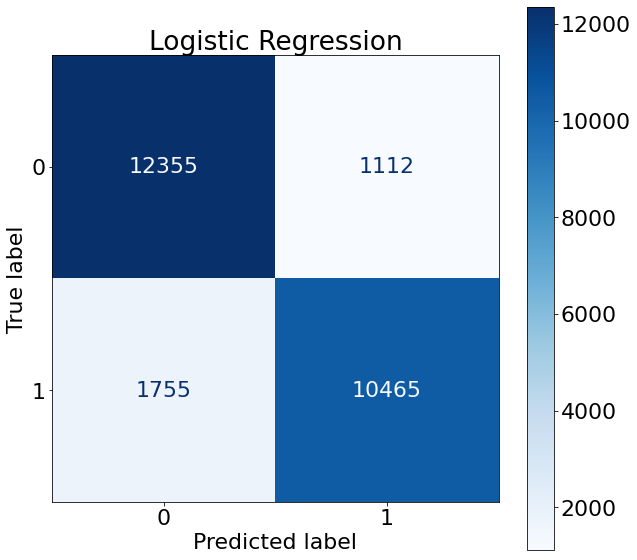

In [56]:
classifiy_metrics(y_test = y_test, 
                    y_preds = preds_gs_cvec_idf_logreg,
                    title="Logistic Regression")

In [25]:
joblib.dump(gs_cvec_idf_logreg,"retrain_gs_cvec_idf_logreg.pkl") # The big Log Reg

['retrain_gs_cvec_idf_logreg.pkl']

#### Random Forest:

In [26]:
ct_pipe_rf_np = Pipeline([
    ('tvec', TfidfVectorizer()),                                   
    ('rf', RandomForestClassifier())
])

pipe_params_ct_rf_np = {
        'tvec__max_df' : [0.95, 0.98],
        'tvec__ngram_range' : [(1, 1), (2,2)],
        'tvec__min_df' : [0.01, 0.02],
        'rf__min_samples_leaf' : [2, 7],
        'rf__ccp_alpha' : [0.01, 0.03]
        
}

# Instantiate GridSearchCV.
gs_ct_rf_np = GridSearchCV(ct_pipe_rf_np,
                      param_grid=pipe_params_ct_rf_np,
                      cv=5,
                      verbose=2,
                      n_jobs=-2)

In [27]:
gs_ct_rf_np.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rf__ccp_alpha': [0.01, 0.03],
                         'rf__min_samples_leaf': [2, 7],
                         'tvec__max_df': [0.95, 0.98],
                         'tvec__min_df': [0.01, 0.02],
                         'tvec__ngram_range': [(1, 1), (2, 2)]},
             verbose=2)

In [28]:
gs_ct_rf_np.best_params_

{'rf__ccp_alpha': 0.01,
 'rf__min_samples_leaf': 7,
 'tvec__max_df': 0.95,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (1, 1)}

In [29]:
classify_score(model = gs_ct_rf_np, 
                X_train = X_train, 
                X_test = X_test, 
                y_test = y_test, 
                y_train = y_train)

Training Score: 0.82821038906253
Testing Score: 0.8243469459259548


In [30]:
preds_gs_ct_rf_np = gs_ct_rf_np.predict(X_test)

Accuracy Score: 0.8243469459259548
Recall Score: 0.7324877250409165
Specificity Score: 0.9077003044479097
Precision Score: 0.8780655287423975
F1 Score: 0.7986972427946819
ROC AUC Score: 0.8200940147444131


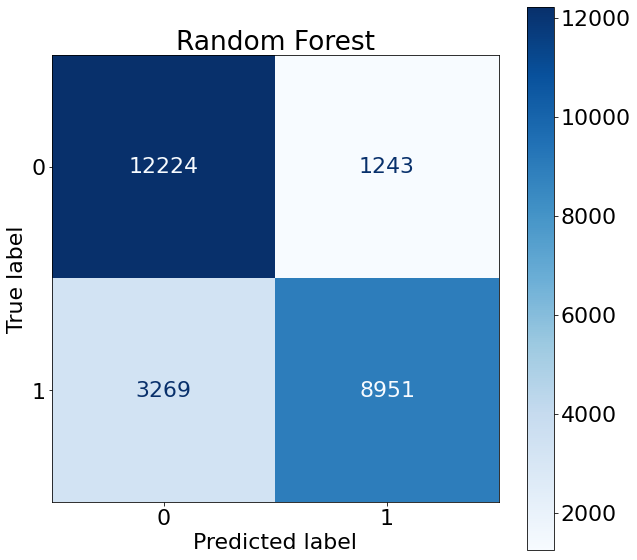

In [57]:
classifiy_metrics(y_test, 
                    preds_gs_ct_rf_np, 
                    title = "Random Forest")

In [32]:
joblib.dump(gs_ct_rf_np,'retrain_gs_random_forest.pkl')
#Joblib instead of pickle

['retrain_gs_random_forest.pkl']

#### Decision Tree:

In [33]:
ct_pipe_dt_np = Pipeline([
    ('tvec', TfidfVectorizer()),                                   
    ('dt', DecisionTreeClassifier())              ## Pipeline always end w estimator
])

pipe_params_ct_dt_np = {
        'tvec__max_df' : [0.95, 0.98],
        'tvec__ngram_range' : [(1, 1), (2,2)],
        'tvec__min_df' : [0.01, 0.02],
        "dt__max_depth":[5,8],
        "dt__ccp_alpha":[0, 0.001]
}

# Instantiate GridSearchCV.
gs_ct_dt_np = GridSearchCV(ct_pipe_dt_np,
                      param_grid=pipe_params_ct_dt_np,
                      cv=5,
                      verbose=2,
                      n_jobs=-2)

In [34]:
gs_ct_dt_np.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-2,
             param_grid={'dt__ccp_alpha': [0, 0.001], 'dt__max_depth': [5, 8],
                         'tvec__max_df': [0.95, 0.98],
                         'tvec__min_df': [0.01, 0.02],
                         'tvec__ngram_range': [(1, 1), (2, 2)]},
             verbose=2)

In [35]:
gs_ct_dt_np.best_params_

{'dt__ccp_alpha': 0,
 'dt__max_depth': 8,
 'tvec__max_df': 0.98,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [36]:
classify_score(model = gs_ct_dt_np, 
                X_train = X_train, 
                X_test = X_test, 
                y_test = y_test, 
                y_train = y_train)

Training Score: 0.8570305459147476
Testing Score: 0.8444349281737844


In [37]:
preds_gs_ct_dt_np = gs_ct_dt_np.predict(X_test)

Accuracy Score: 0.8444349281737844
Recall Score: 0.8120294599018003
Specificity Score: 0.8738397564416722
Precision Score: 0.853811736362072
F1 Score: 0.8323966110225653
ROC AUC Score: 0.8429346081717362


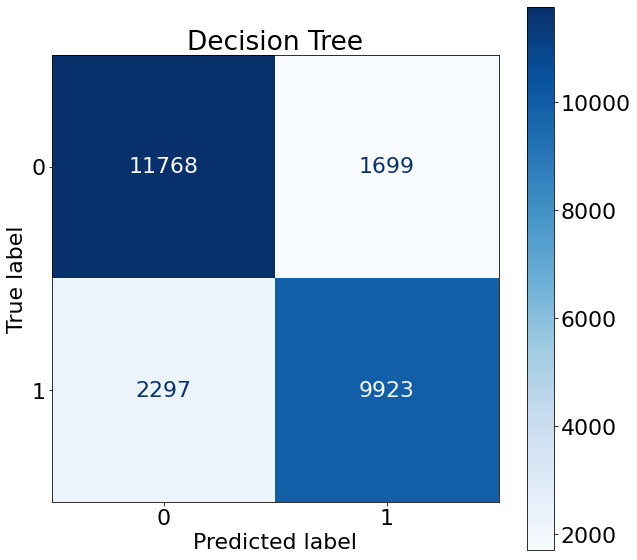

In [58]:
classifiy_metrics(y_test = y_test, 
                    y_preds = preds_gs_ct_dt_np, title= 'Decision Tree')

In [39]:
joblib.dump(gs_ct_dt_np,'retrain_gs_ct_dt_np.pkl')

['retrain_gs_ct_dt_np.pkl']

#### KNN:

In [40]:
ct_pipe_knn_np = Pipeline([
    ('tvec', TfidfVectorizer()),                                   
    ('knn', KNeighborsClassifier())              ## Pipeline always end w estimator
])

pipe_params_ct_knn_np = {
        'tvec__max_df' : [0.95, 0.98],
        'tvec__ngram_range' : [(1, 1), (2,2)],
        'tvec__min_df' : [0.01, 0.02],
        'knn__n_neighbors': (5,7),
        'knn__leaf_size': (15, 30),
        'knn__weights': ('uniform', 'distance')
}

# Instantiate GridSearchCV.
gs_ct_knn_np = GridSearchCV(ct_pipe_knn_np,
                      param_grid=pipe_params_ct_knn_np,
                      cv=5,
                      verbose=2,
                      n_jobs=-2)

In [41]:
gs_ct_knn_np.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'knn__leaf_size': (15, 30), 'knn__n_neighbors': (5, 7),
                         'knn__weights': ('uniform', 'distance'),
                         'tvec__max_df': [0.95, 0.98],
                         'tvec__min_df': [0.01, 0.02],
                         'tvec__ngram_range': [(1, 1), (2, 2)]},
             verbose=2)

In [42]:
gs_ct_knn_np.best_params_

{'knn__leaf_size': 15,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance',
 'tvec__max_df': 0.95,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (2, 2)}

In [43]:
classify_score(gs_ct_knn_np, X_train, X_test, y_train, y_test)

Training Score: 0.9020153017200053
Testing Score: 0.7431774827733874


In [44]:
preds_gs_ct_knn_np = gs_ct_knn_np.predict(X_test)

Accuracy Score: 0.7431774827733874
Recall Score: 0.6565466448445172
Specificity Score: 0.8217865894408555
Precision Score: 0.7697399980811667
F1 Score: 0.7086516804310382
ROC AUC Score: 0.7391666171426862


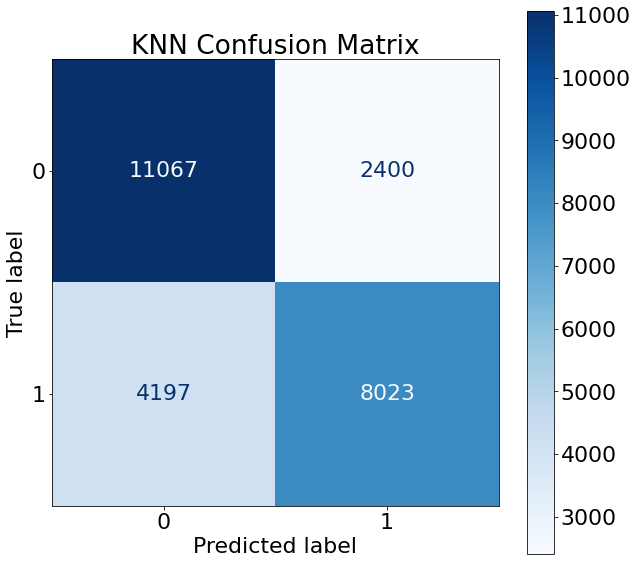

In [45]:
classifiy_metrics(y_test = y_test, 
                    y_preds = preds_gs_ct_knn_np,
                    title="KNN")

In [46]:
joblib.dump(gs_ct_knn_np,'retrain_gs_ct_knn_np.pkl')

['retrain_gs_ct_knn_np.pkl']

#### SVC:

In [47]:
cvec_idf_svc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('svc', SVC())
])

pipe_params_cidf_svc = {
        'cvec__max_df' : [0.95, 0.98],
        'cvec__ngram_range' : [(1, 1), (2, 2)],
        'cvec__min_df' : [0.02, 0.01],
        'tfidf__use_idf': [True, False],
        'svc__C': (0.001, 2)
}

# Instantiate GridSearchCV.
gs_cvec_idf_svc = GridSearchCV(cvec_idf_svc_pipe,
                      param_grid=pipe_params_cidf_svc,
                      cv=5,
                      verbose=2,
                      n_jobs=-2)


# Fit GridSearch to training data.
gs_cvec_idf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svc', SVC())]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.95, 0.98],
                         'cvec__min_df': [0.02, 0.01],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'svc__C': (0.001, 2),
                         'tfidf__use_idf': [True, False]},
             verbose=2)

In [48]:
gs_cvec_idf_svc.best_params_

{'cvec__max_df': 0.95,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'svc__C': 2,
 'tfidf__use_idf': False}

In [49]:
classify_score(model = gs_cvec_idf_svc, 
                X_train = X_train,
                X_test = X_test, 
                y_train = y_train, 
                y_test = y_test)

Training Score: 0.9935571705240551
Testing Score: 0.9042317125394168


In [50]:
preds_gs_cvec_idf_svc = gs_cvec_idf_svc.predict(X_test)

In [52]:
joblib.dump(gs_cvec_idf_svc,'retrain_gs_svc.pkl')

['retrain_gs_svc.pkl']

In [12]:
# Reloading model to update visualizations otherwise running the model will take around 441 minutes
svc = joblib.load('./retrain pickles/retrain_gs_svc.pkl')

In [13]:
preds_svc = svc.predict(X_test)

Accuracy Score: 0.9042317125394168
Recall Score: 0.8800327332242226
Specificity Score: 0.926189945793421
Precision Score: 0.9153898535921008
F1 Score: 0.8973631508678238
ROC AUC Score: 0.9031113395088218


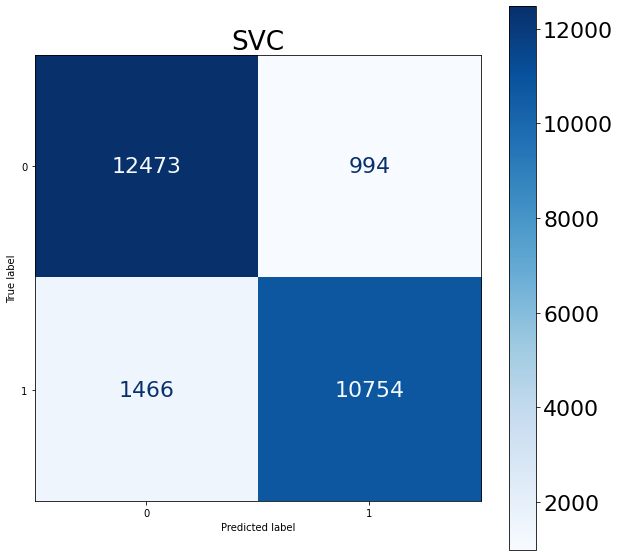

In [14]:
classifiy_metrics(y_test = y_test, y_preds = preds_svc, title = 'SVC')